# Germ cell lineage - Seurat analysis

Please, save the anndata object with scanpy < 7.0

In [5]:
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(SoupX)

colors = c('#db7293', 
           brewer.pal(n=12, name = 'Paired'), 
           brewer.pal(n=8, name = 'Set2'),
          brewer.pal(n=8, name = 'Set3'),
          brewer.pal(n=8, name = 'Accent'),
          brewer.pal(n=8, name = 'Pastel1'))[-14]

In [6]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /home/jovyan/my-conda-envs/R_Seurat3/lib/libblas.so.3.8.0
LAPACK: /home/jovyan/my-conda-envs/R_Seurat3/lib/liblapack.so.3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SoupX_1.5.0        cowplot_1.1.1      pheatmap_1.0.12    ggplot2_3.3.3     
 [5] harmony_1.0        Rcpp_1.0.6         gam_1.20           foreach_1.5.1     
 [9] destiny_3.4.0      RColorBrewer_1.1-2 dplyr_1.0.5        Seurat_3.

In [7]:
markers = list( 
                PGCs= c('POU5F1', 'NANOG', 'NANOS3', 'SOX17', 'IFITM1', 'XIST'),
                GCs = c('DAZL', 'DDX4', 'MAEL'),
                oogenesis = c('ZGLP1'), 
                RA = c('STRA8', 'ESX1'), 
                meiosis = c('MEIKIN', 'SYCP1', 'MEIOC'), 
                oocyte = c('FIGLA','OOSP2', 'GDF9', 'ZP3', 'FOXO3','SOHLH1', 'SOHLH2', 'NOBOX', 'LHX8', 'YBX2', 'TSC2'),
                pre_spermatogonia=c('MORC1', 'PIWIL4', 'NKAPL', 'VCX3A'),
                mesothelial = c('LRRN4', 'UPK3B', 'KLK11'),
                gonad_somatic_cells = c('NR5A1', 'AMHR2', 'SPRR2F',  'MIR202HG'),
                germcells = c('WNT6', 'WIPF3'),
                preGranulosa_lineage = c("KITLG",  'RSPO1', 'OSR1' , 'NR4A1'),
                sertoli_lineage = c('SOX9', 'INHBB', 'AMH', 'CLDN11', 'INHA'),
                mesenchymal_steroidogenic = c('CYP11A1', 'CYP17A1', 'STAR',  'MGARP'),
                mesenchymal = c('DCN', 'PDGFRA','TCF21', 'OGN', 'POSTN'),
                gonadal_mesenchymal = c('LHX9', 'GATA4'),
                extragonadal_mesen = c('GATA2', 'NR2F1', 'WNT4', 'RSPO3'),
                gonad_dev = c('EMX2', 'WT1'),
                muscoskeletal = c('MYF5','PAX7','MYF6'),
                epithelial = c("EPCAM"),
                immune= c('PTPRC', 'DEFA3'),
                endothelial = c('PECAM1', 'VWF', 'CDH5'),
                erythroid = c("GYPC", "HBA1"),
                neural = c('ASCL1', 'ELAVL4'),
                PV = c("PDGFRB", 'ACTA2'),
                cycling = c('CDK1', 'MKI67'),
                quiescent = c('CDKN1B'),
                male = c('SRY', 'RPS4Y1','DDX3Y')       
)
unlist(markers)[ which(duplicated(unlist(markers))) ]


markers_i = list( immune=c('PTPRC'),
                 B_cells = c('CD79B', 'MS4A1', 'TCL1A', 'IGKC', 'JCHAIN', 'IGLL1', 'LTB'),
                    dendritic = c('CD1C', 'PLAC8', 'HLA-DRA', 'CLEC9A'),
                    NKs = c('GNLY', 'NKG7', 'NCAM1', 'CD7', 'IL2RB', 'CD3E' ),
                    ILCs = c('KLRB1', 'IL32',  'GATA3', 'CD3D'),
                    Mast = c('KIT', 'TPSAB1', 'SERPINB1'),
                    Monocytes = c('S100A9', 'LYZ', 'FCGR3A'),
                    HSCs = c('CD34', 'SPINK2'),
                    Megakaryocytes = c('ESAM', 'GATA1', 'ITGA2B', 'PF4'),
                    Early_erythroid = c('KLF1'),
                    Mid_erythroid = c('HBA1', 'ALAS2', 'GYPA'),
                    Late_erythroid = c('BPGM'), # less KLF1 and GATA1 
                    Macrophages = c('SELENOP', 'C1QA', 'CD4', 'CD14', 'CCL4', 'ADGRE1',  'ITGAM', 'ITGAX', 'CD68'),
                    neutrophils=c('LTF', 'LCN2', 'CAMP', 'PGLYRP1', 'S100A8', 'S100A12'),
                    neutrophil_myeloid_prog=c('POU5F1', 'MPO', 'DEFA3')
                 )
unlist(markers_i)[ which(duplicated(unlist(markers_i))) ]

named character(0)

named character(0)

# Process with Seurat from raw

In [8]:
# Load and pre-process wth standard workflow
anndata <- ReadH5AD(file = '/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.h5ad')
allgenes = rownames(anndata)
anndata

Warning message:
“Functionality for reading and writing H5AD files is being moved to SeuratDisk
For more details, please see https://github.com/mojaveazure/seurat-disk
and https://mojaveazure.github.io/seurat-disk/index.html”
Pulling expression matrices and metadata

Data is unscaled

Creating assay object

Storing X as raw and raw as counts

No variable feature expression found in h5ad file

No dimensional reduction information found

Assembling Seurat object

No nearest-neighbor graph

No additional layers found



An object of class Seurat 
28230 features across 319081 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

In [9]:
# Add metadata
meta = read.csv('/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.csv', stringsAsFactors = F)
names(meta)[1] = 'index'
anndata@meta.data$is_doublet = meta$is_doublet[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$clusters = meta$clusters_manual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$PCW = meta$PCW[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)
anndata@meta.data$sex = meta$sex[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$TP = meta$TP[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$process = meta$process[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$individual = meta$individual[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$sample_source = meta$sample_source[ match(rownames(anndata@meta.data), meta$index) ]
anndata@meta.data$scrublet_cluster_score = meta$scrublet_cluster_score[ match(rownames(anndata@meta.data), meta$index) ] %>% as.numeric(.)
table(anndata@meta.data$clusters)


               Coel Epi                Doublets             Endothelial 
                  12001                    5639                   10948 
             Epithelial               Erythroid              Germ cells 
                   9679                    7423                   11388 
                 Immune                   lowQC Mesenchymal_GATA2_NR2F1 
                   5157                   20815                   77319 
   Mesenchymal_LHX9_ARX             Metanephros                  Neural 
                  51992                    1503                    2530 
                     PV                 Sertoli       Supporting_female 
                   7440                   37796                   57451 

In [10]:
table(anndata@meta.data$clusters)


               Coel Epi                Doublets             Endothelial 
                  12001                    5639                   10948 
             Epithelial               Erythroid              Germ cells 
                   9679                    7423                   11388 
                 Immune                   lowQC Mesenchymal_GATA2_NR2F1 
                   5157                   20815                   77319 
   Mesenchymal_LHX9_ARX             Metanephros                  Neural 
                  51992                    1503                    2530 
                     PV                 Sertoli       Supporting_female 
                   7440                   37796                   57451 

In [11]:
# subset datasets to contain clusters of interest and remove doublets
clusters_of_interest = c('Germ cells')
anndata = subset(anndata, cells = rownames(subset(anndata@meta.data, clusters %in% clusters_of_interest)))
anndata
all(clusters_of_interest %in% anndata@meta.data$clusters)

An object of class Seurat 
28230 features across 11388 samples within 1 assay 
Active assay: RNA (28230 features, 0 variable features)

[1] TRUE

In [12]:
# basic gene/cell filtering
gene_counts = apply(anndata@assays$RNA@counts, 1, function(xx) sum(xx>0) )
message('Removing ', sum(gene_counts <= 3), ' genes' )
anndata <- subset(anndata, features = names(gene_counts)[ gene_counts > 3 ] )
                    
cell_counts = apply(anndata@assays$RNA@counts, 2, function(xx) sum(xx>0) )
message('Removing ', sum(cell_counts <= 300), ' cells' )
anndata <- subset(anndata, cells = names(cell_counts)[ cell_counts > 300 ] )

Removing 4227 genes

Removing 0 cells



In [13]:
# basic preprocessing
# suppressWarnings(anndata <- SCTransform(anndata, verbose = F))
anndata <- NormalizeData(anndata, normalization.method = "LogNormalize", scale.factor = 10000)
anndata <- FindVariableFeatures(anndata)
anndata <- ScaleData(anndata, features = rownames(anndata))
anndata

Centering and scaling data matrix



An object of class Seurat 
24003 features across 11388 samples within 1 assay 
Active assay: RNA (24003 features, 2000 variable features)

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”
Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 3 features requested have not been scaled (running reduction without them): MLF1IP, FAM64A, HN1”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  TOP2A, UBE2C, HMGB2, NUSAP1, MKI67, HJURP, CDCA3, BIRC5, CDK1, TPX2 
	   CDC20, CLSPN, KIF2C, SMC4, GTSE1, CDCA2, CENPF, CDCA8, CENPA, CCNB2 
	   KIF23, CKS2, ATAD2, TACC3, ANLN, CKS1B, DLGAP5, TYMS, SLBP, MCM6 
Negative:  GAS2L3, UHRF1, POLA1, MSH2, RANGAP1, PSRC1, RAD51, CTCF, UBR7, E2F8 
	   CCNE2, MCM5, BRIP1, RFC2, WDR76, RPA2, CHAF1B, TIPIN, GINS2, POLD3 
	   CDCA7, G2E3, CASP8AP2, DTL

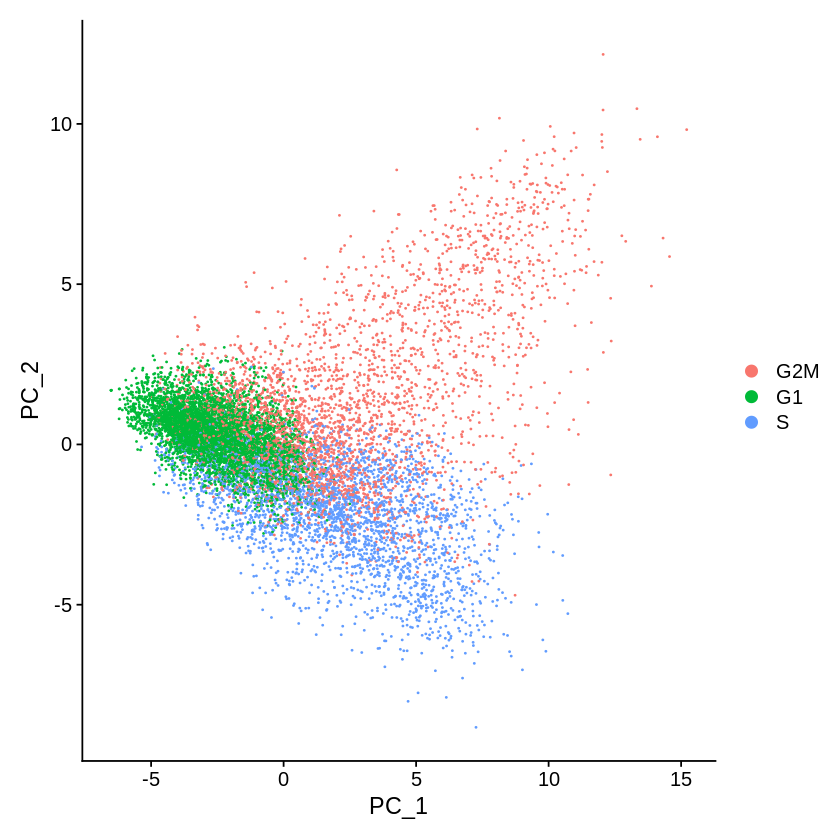

In [14]:
# check cell cycle effect
anndata <- CellCycleScoring(anndata, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, set.ident = TRUE)
anndata <- RunPCA(anndata, features = c(cc.genes$s.genes, cc.genes$g2m.genes))
DimPlot(anndata, reduction = 'pca')

In [15]:
anndataO = anndata
# Regress out cell cycle - NOTE: subset the dataset to speed up process
anndata = subset(anndata, features = VariableFeatures(object = anndata))
# anndata <- ScaleData(anndata, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(anndata))
anndata <- ScaleData(anndata, vars.to.regress = c("nCount_RNA"), features = rownames(anndata))

Regressing out nCount_RNA

Centering and scaling data matrix



PC_ 1 
Positive:  STK31, COX8C, PAGE2B, TEX30, SYCP3, SMC1B, PDHA1, SYCP2, C5orf47, MAEL 
	   SLC25A31, CENPU, SCCPDH, C14orf39, BAZ1A, INCA1, FKBP2, IQCB1, SPATA22, PSMD10 
	   SRP9, CCDC73, C15orf48, BUD23, HORMAD1, B2M, STAG3, REXO5, BAIAP2L1, SYCP1 
Negative:  APOE, POU5F1, SLC25A6, NANOS3, PDPN, NANOG, RPL39, GLIPR2, ITM2C, ALPL 
	   L1TD1, MKRN1, APOC1, SOX15, RPS4X, SAT1, IFITM1, RGS10, ETV4, DDIT4 
	   TPM4, RPL26, MMP2, PLBD1, THY1, ETV5, RPS2, PQLC3, S100A13, UTF1 
PC_ 2 
Positive:  SMC1B, HMGB2, HPRT1, SPATA22, SYCP3, ZCWPW1, TEX30, NMU, ESCO2, MDK 
	   INCA1, TRIP13, IQCB1, RAD51AP2, PIGP, HORMAD1, CENPU, SHCBP1L, SPO11, SYCE2 
	   SMC3, SYNGR4, SPDYA, REXO5, CCDC152, HIST1H4C, IFT81, PRKACB, MEIOC, DMRTB1 
Negative:  ZP3, PADI6, IGHEP1, FAM167A-AS1, UNC13C, LINC02303, NLRP5, MVP, AC022113.1, KPNA7 
	   CTRB2, TUBB8P12, GLRX, WFDC2, OOSP2, DMD, PFKP, IGHE, LAD1, SHD 
	   ARHGAP15, TUBB8, SERPINF1, EFCAB10, PSTPIP1, TUBA4B, SMARCA2, PLEK2, FIGLA, LDHAL6A 
PC_ 3 
Positive:  C

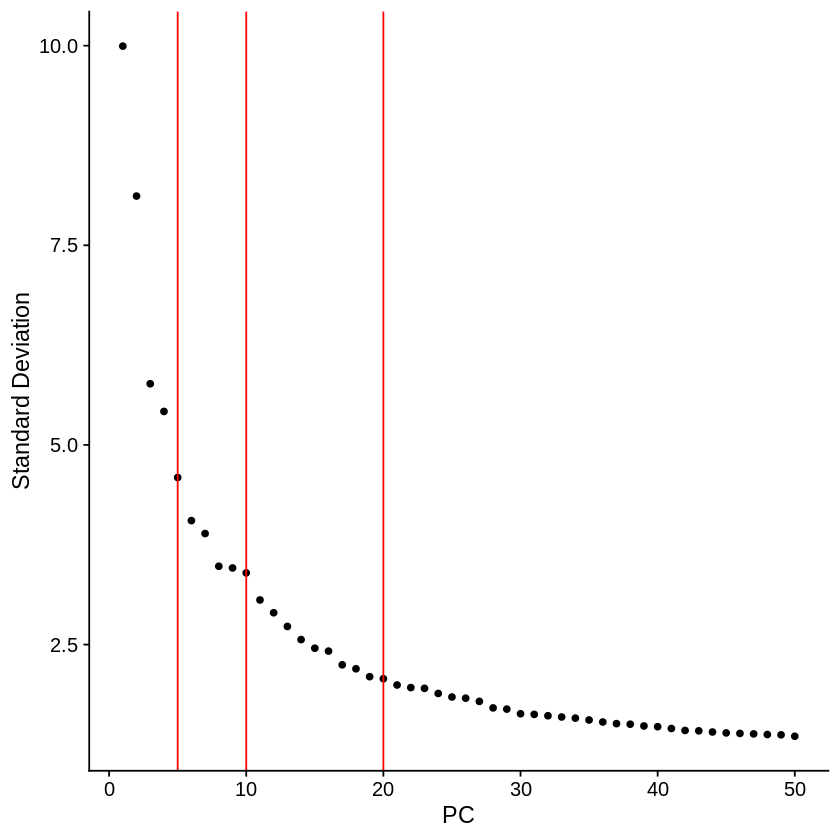

In [16]:
# Compute PCA
anndata <- RunPCA(anndata, features = VariableFeatures(object = anndata), seed.use = 1)
ElbowPlot(anndata, ndims = 50) + geom_vline(xintercept = 5, color = 'red') + geom_vline(xintercept = 10, color = 'red') + geom_vline(xintercept = 20, color = 'red')

In [17]:
npca = 16
# Correct donor's effect on PCA
anndata <- RunHarmony(anndata, group.by.vars = 'individual', dims.use = 1:npca, theta = 0)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony converged after 8 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [18]:
# Cluster
# anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "pca", verbose = F)
# anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "pca", verbose = F)
anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "harmony", verbose = F)
anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "harmony", verbose = F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [19]:
# anndata <- FindClusters(anndata, resolution = 0.8)
anndata <- FindClusters(anndata, resolution = 0.4)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11388
Number of edges: 420359

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9314
Number of communities: 14
Elapsed time: 1 seconds


In [20]:
# Transfer data
all(rownames(anndataO) == rownames(anndata))
anndataO$seurat_clusters = anndata$seurat_clusters
Idents(anndataO) = Idents(anndata)

anndataO@reductions = anndata@reductions

Warning message in rownames(anndataO) == rownames(anndata):
“longer object length is not a multiple of shorter object length”


[1] FALSE

Saving 6.67 x 6.67 in image



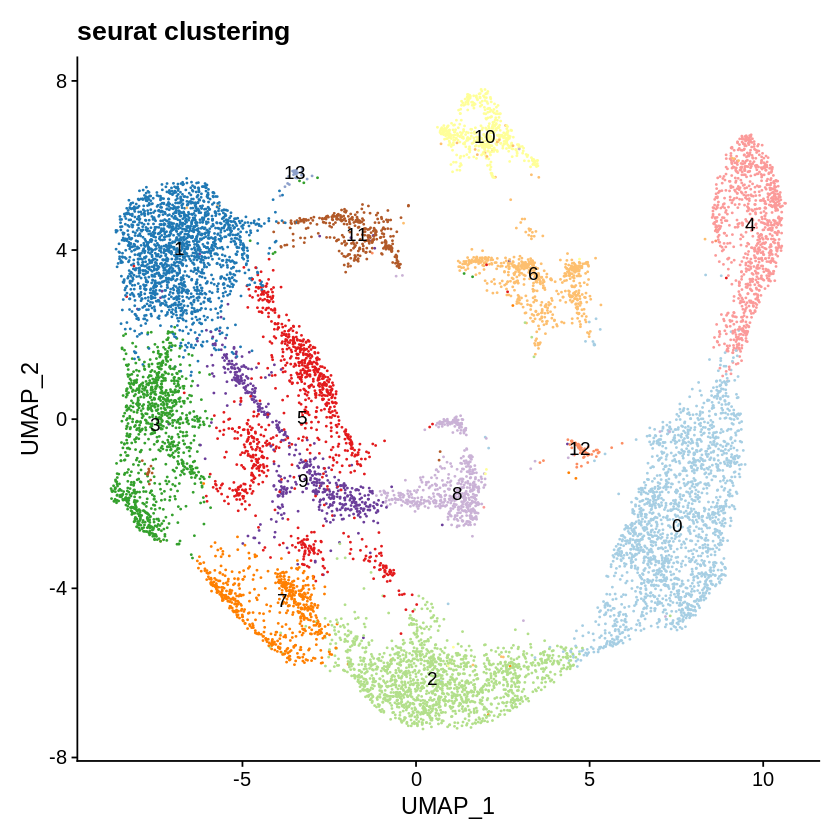

In [22]:
# Visualize
p1 = DimPlot(anndata, reduction = "umap", label = T, cols = colors[-1]) + ggtitle('seurat clustering') + NoLegend()
p1
ggsave(filename = paste0('figures-germcells/umap_clustering.pdf'), dpi = 75)

In [23]:
meta_sup = read.csv('/nfs/team292/lg18/with_valentina/gonadsV1_freezed/germcells_annotated.csv', stringsAsFactors = F)

# Add metadata
anndata@meta.data$clusters_old = 'new'
anndata@meta.data$clusters_old[ rownames(anndata@meta.data) %in% meta_sup$X ] = 
meta_sup$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_sup$X], meta_sup$X) ]



meta_sup = read.csv('../scRNAseq_analysis_FCA_2sex/figures-containsGermcells/female_metadata_annotated.csv', stringsAsFactors = F)

# Add metadata
anndata@meta.data$clusters_sex = 'new'
anndata@meta.data$clusters_sex[ rownames(anndata@meta.data) %in% meta_sup$X ] = 
meta_sup$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_sup$X], meta_sup$X) ]


meta_sup = read.csv('../scRNAseq_analysis_FCA_2sex/figures-containsGermcells/male_metadata_annotated.csv', stringsAsFactors = F)
anndata@meta.data$clusters_sex[ rownames(anndata@meta.data) %in% meta_sup$X ] = 
meta_sup$annotated_clusters[ match(rownames(anndata@meta.data)[rownames(anndata@meta.data) %in% meta_sup$X], meta_sup$X) ]

Saving 13.3 x 13.3 in image



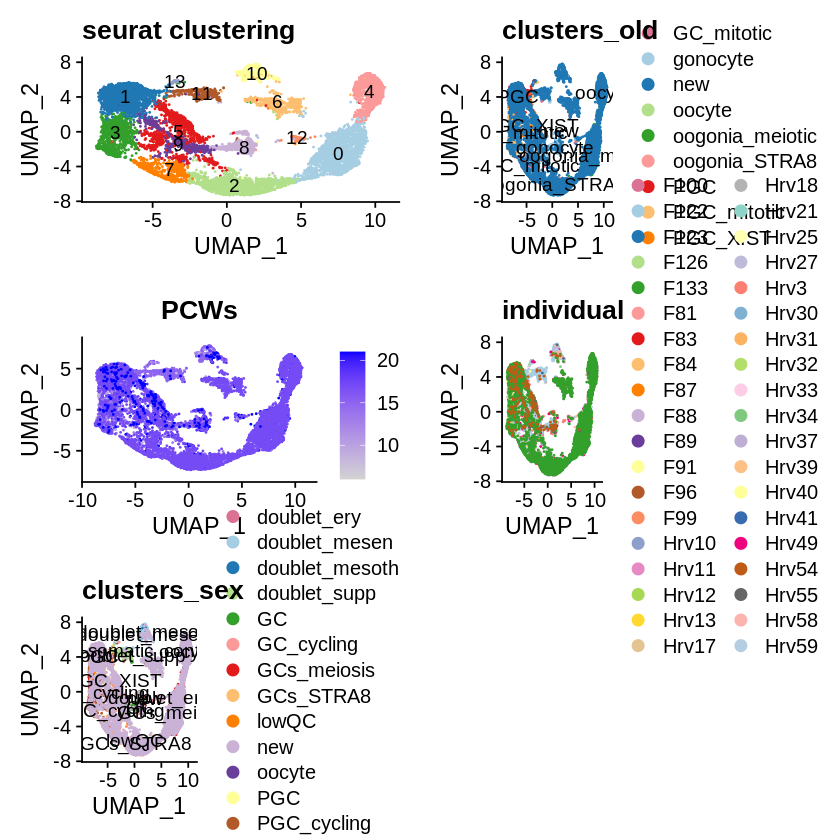

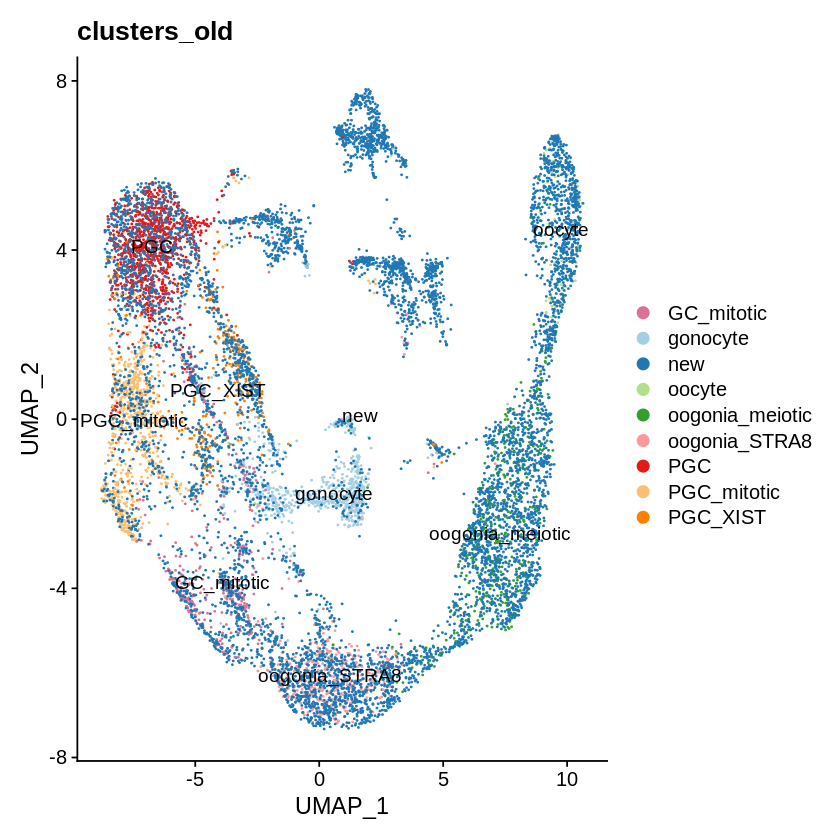

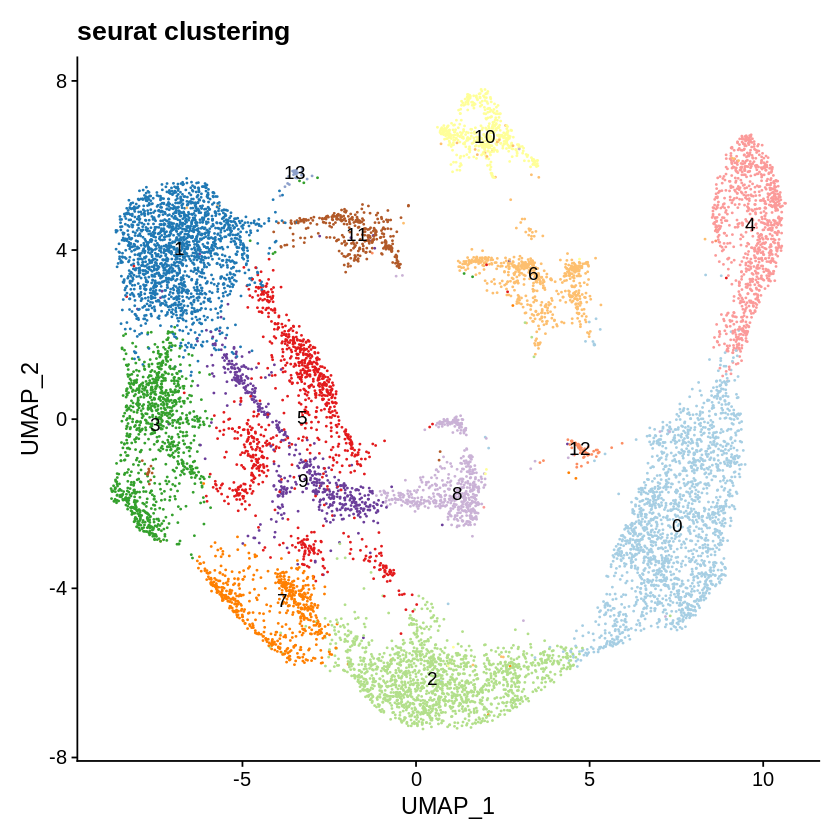

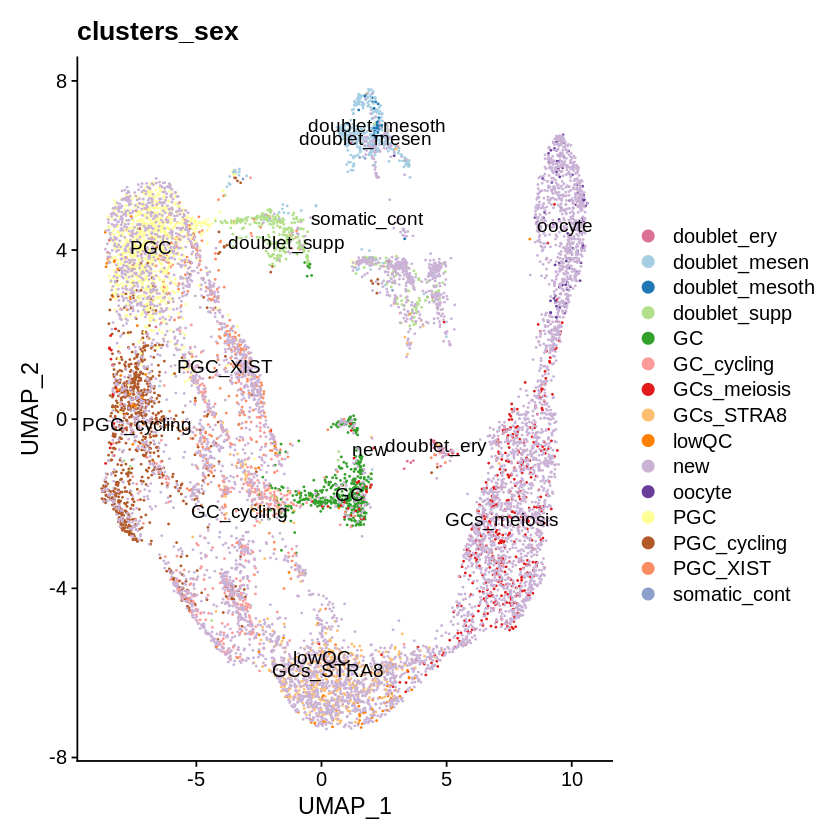

In [24]:
p2 = DimPlot(anndata, reduction = "umap", group.by = 'clusters_old', label = T, cols = colors) + ggtitle('clusters_old')
p3 = FeaturePlot(anndata, reduction = "umap", 'PCW') + ggtitle('PCWs')
p4 = DimPlot(anndata, reduction = "umap", group.by = 'individual', cols = colors) + ggtitle('individual')
p5 = DimPlot(anndata, reduction = "umap", group.by = 'clusters_sex', label = T, cols = colors) + ggtitle('clusters_sex')
plot_grid(p1, p2, p3, p4, p5, ncol = 2)
ggsave(filename = paste0('figures-germcells/umap_metadata.pdf'), scale = 2, dpi = 75)
p2
p1
p5

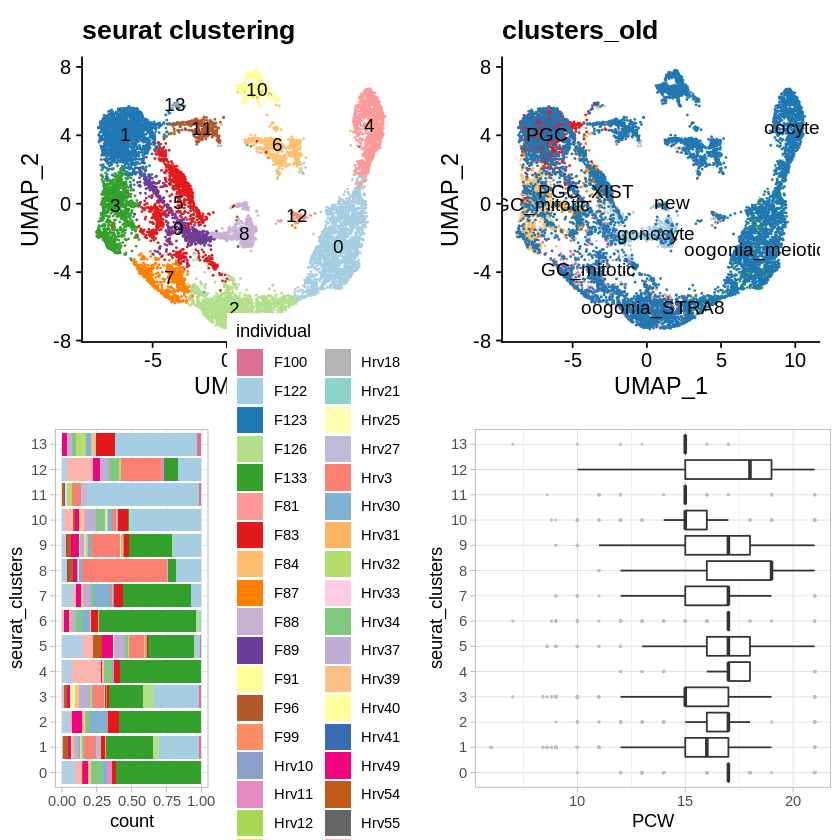

In [25]:
b1 = ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b2 = ggplot(anndata@meta.data, aes(x = seurat_clusters, y = PCW)) + 
    geom_boxplot(outlier.colour =  'grey', outlier.size = 0.2) + 
    coord_flip() +
    theme_light()
plot_grid(p1, p2+ NoLegend(), b1, b2, ncol = 2)
ggsave(filename = paste0('figures-germcells/metadata.pdf'), dpi = 75, width = 10, height = 10)

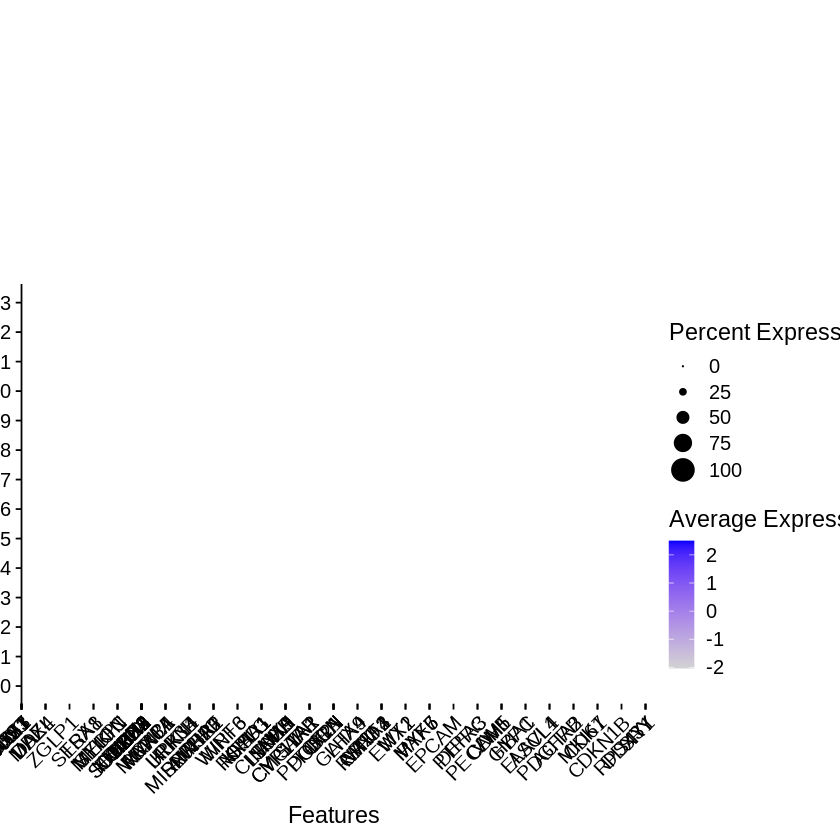

In [26]:
DotPlot(anndataO, features = markers, group.by = 'seurat_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-germcells/dotplot_markers.pdf'), width = 25, height = 7, dpi = 75)

Warning message in FetchData(object = object, vars = features, cells = cells):
“The following requested variables were not found: CD1C, TPSAB1”


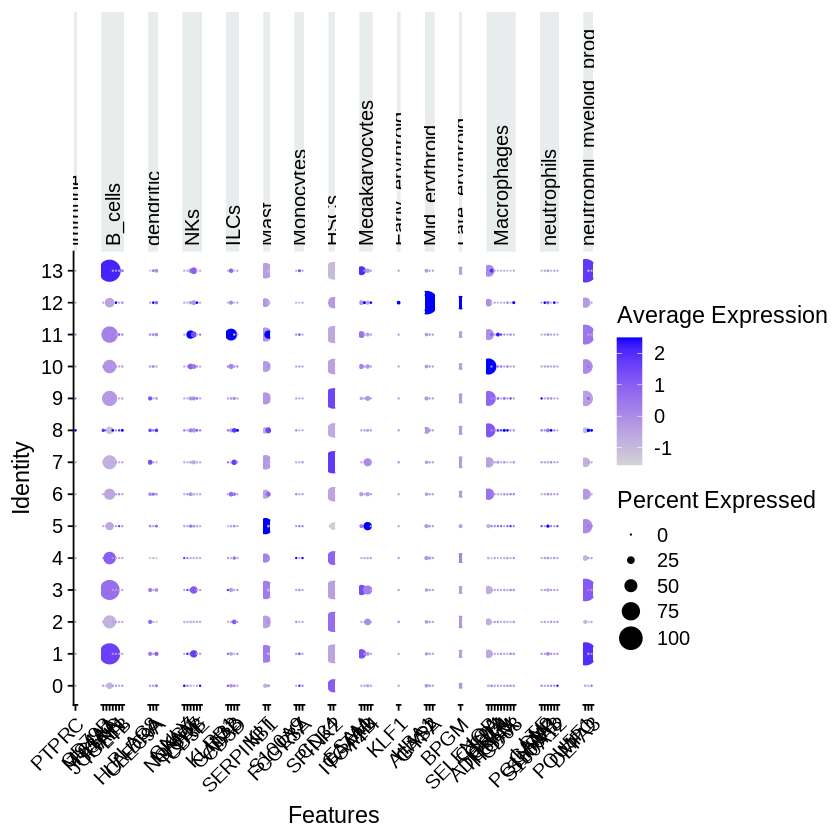

In [27]:
DotPlot(anndataO, features = markers_i, group.by = 'seurat_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-germcells/dotplot_markersImmune.pdf'), width = 25, height = 7, dpi = 75)

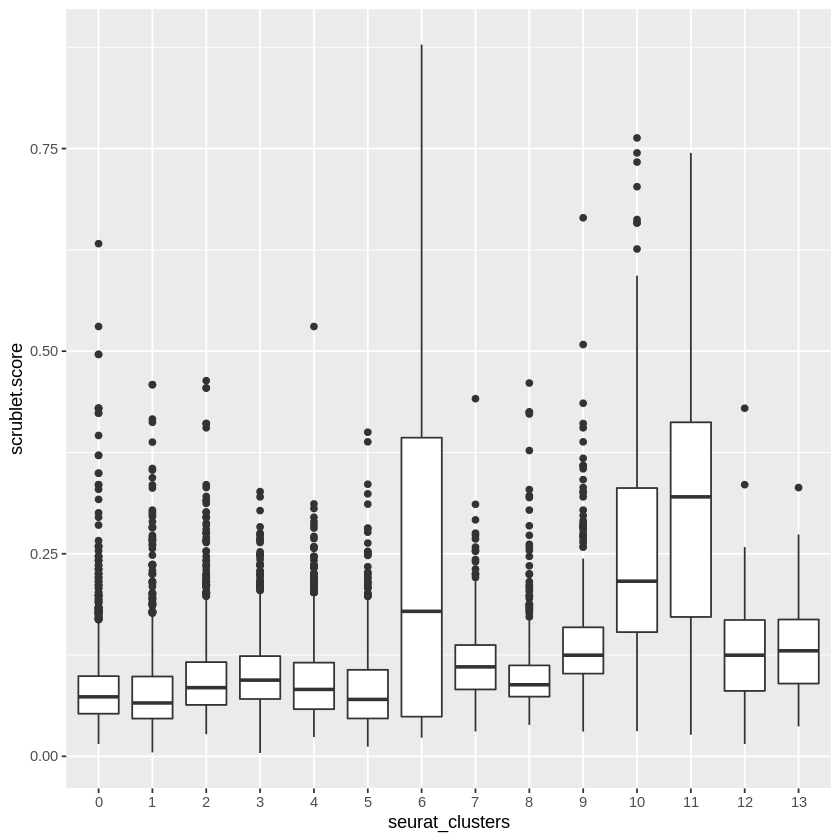

In [28]:
ggplot(anndata@meta.data, aes(y=scrublet.score, x=seurat_clusters)) + geom_boxplot()

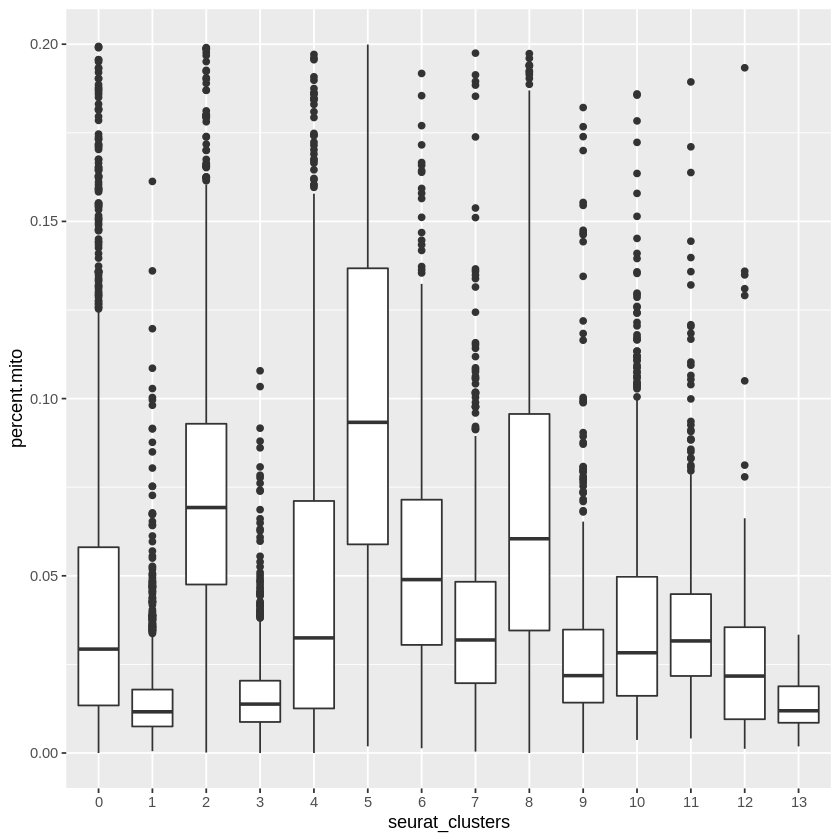

In [29]:
ggplot(anndata@meta.data, aes(y=percent.mito, x=seurat_clusters)) + geom_boxplot()

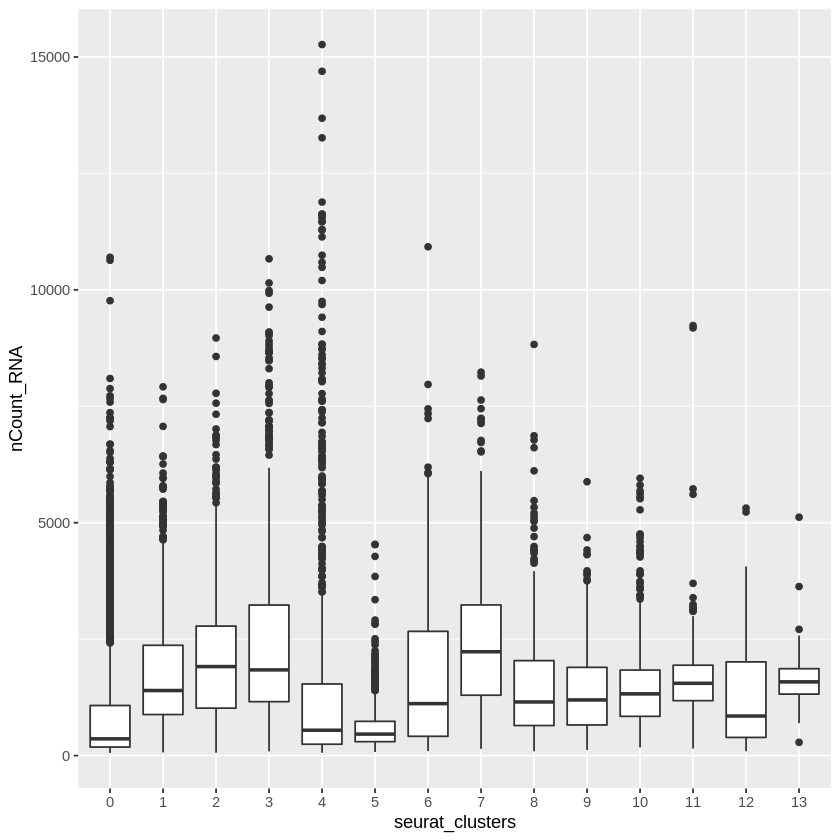

In [34]:
ggplot(anndata@meta.data, aes(y=nCount_RNA, x=seurat_clusters)) + geom_boxplot()

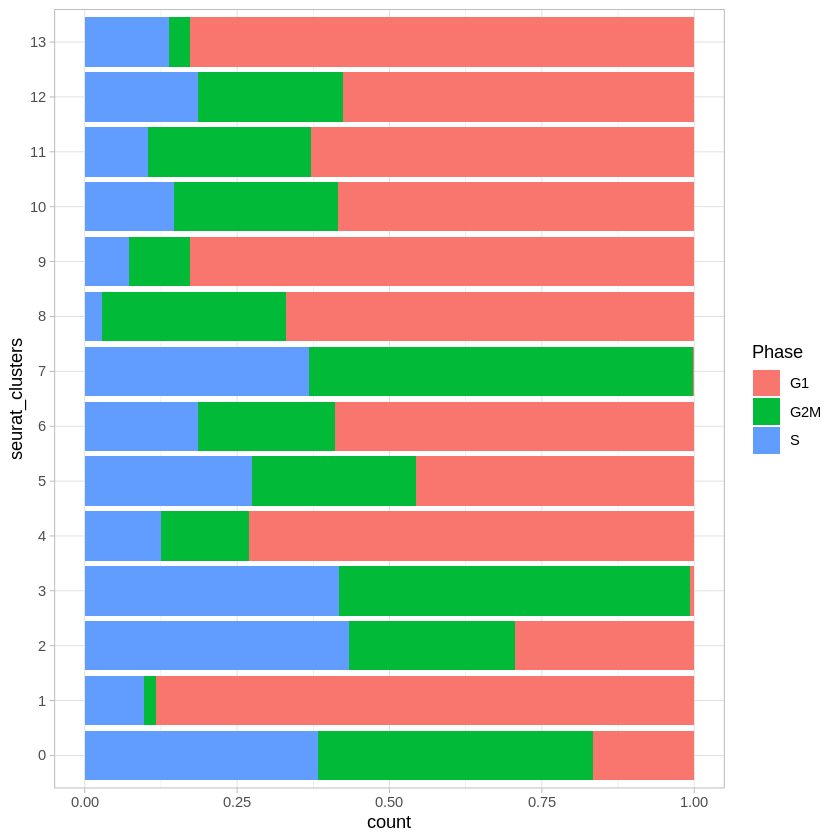

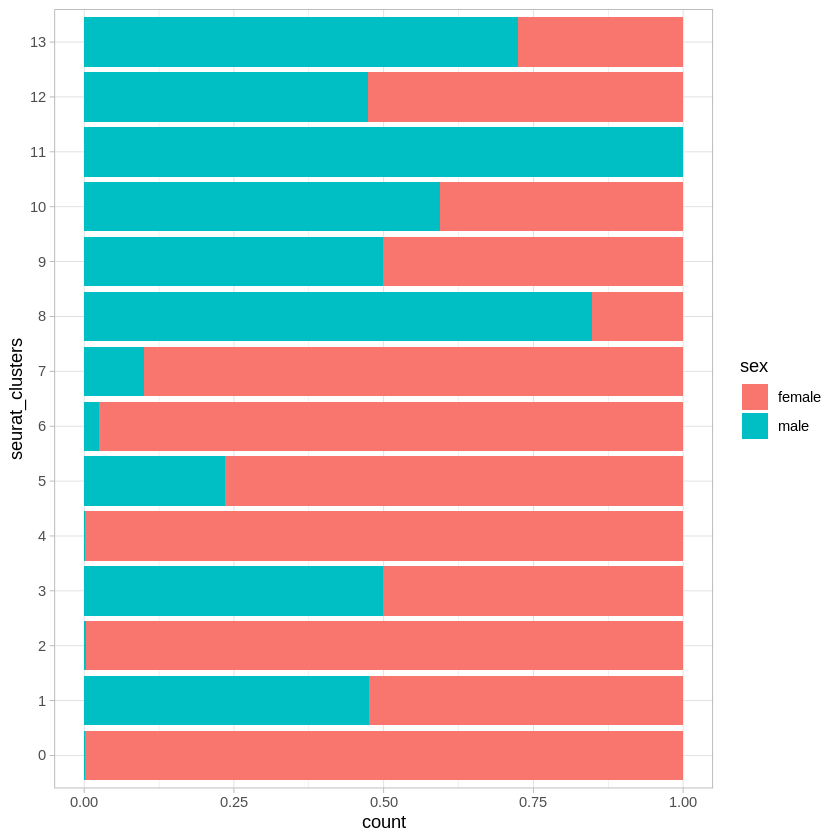

In [35]:
ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = Phase)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()

ggplot(anndata@meta.data, aes(x = seurat_clusters, fill = sex)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()

# QuickMarkers

In [36]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 20)
dim(df_tfIDF)
# write.csv(df_tfIDF, file = 'figures-germcells/cluster_markersTFIDF.csv', quote = F, row.names = F)

[1] 280  10

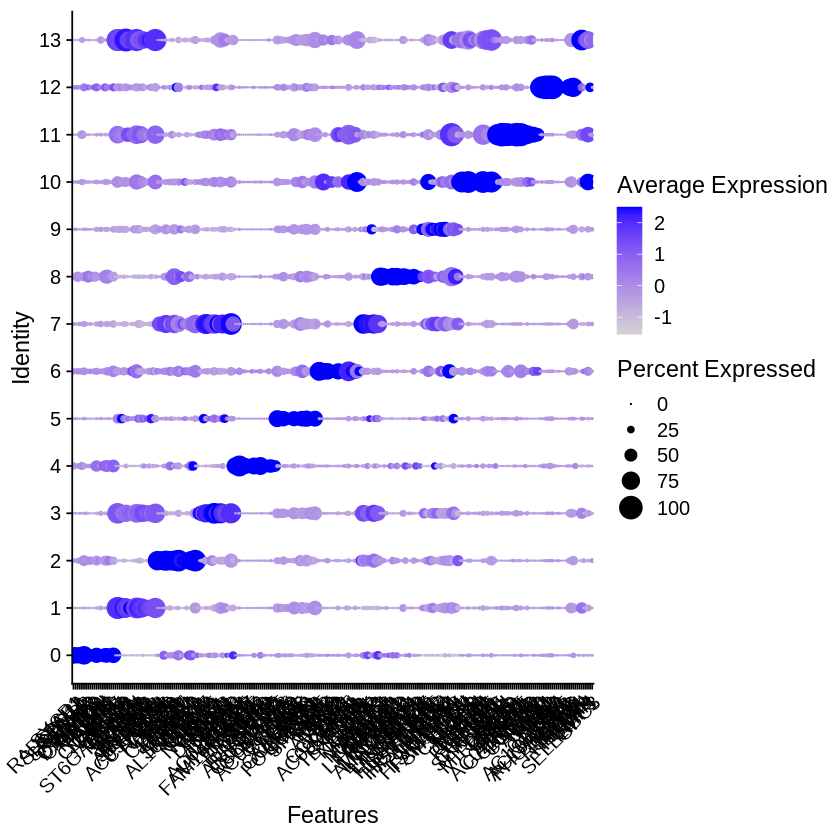

In [37]:
df_tfIDF$cluster = as.numeric(df_tfIDF$cluster)
df_tfIDF = df_tfIDF[ order(df_tfIDF$cluster), ]
DEGs = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 20L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs), group.by = 'seurat_clusters') + RotatedAxis()
ggsave(filename = paste0('figures-germcells/dotplot_TFIDF_DEGs.pdf'), dpi = 75, height = 7, width = 45)

## Annotate cells

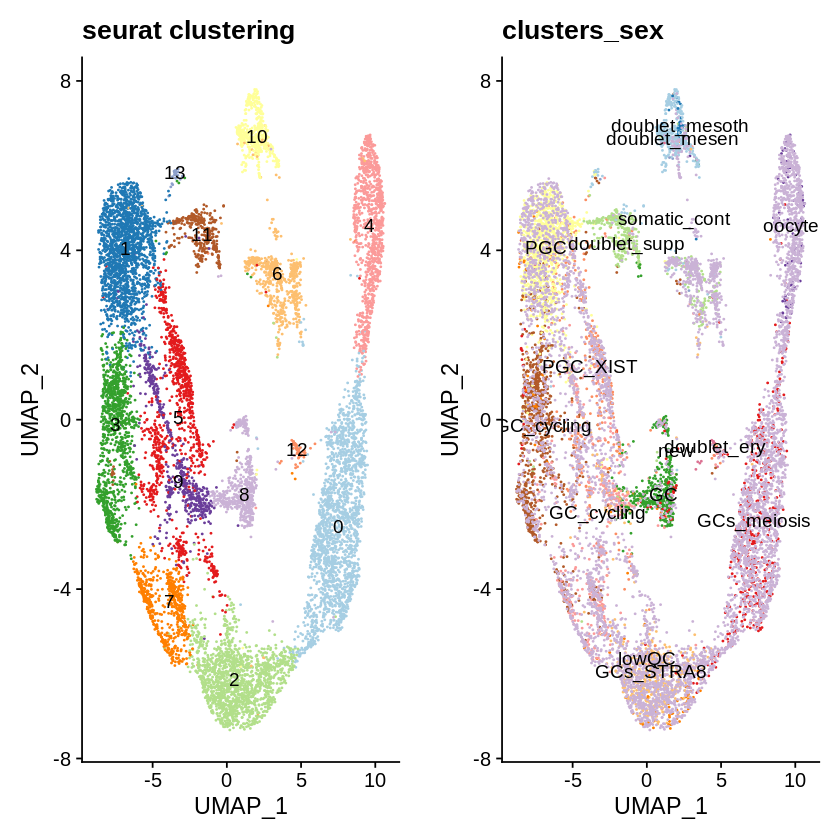

In [38]:
plot_grid(p1, p5+ NoLegend(), ncol = 2)

In [39]:
cluster_names = c('oogonia_meiosis', #0
                  'PGC',
                  'oogonia_STRA8',
                  'PGC_mitotic',
                  'oocyte',
                  'PGC_lowQC',#5
                  'doublet_I',
                  'GC_mitotic',
                  'pre-spermatogonia',
                  'GC',
                  'doublet_II',#10
                  'doublet_III', 
                  'lowQC',
                  'doublet_IV'
                 )


anndata@meta.data$annotated_clusters = cluster_names[ match(anndata@meta.data$seurat_clusters, 
                                                            as.numeric(levels(anndata@meta.data$seurat_clusters)) ) ]

anndata@meta.data$annotated_clusters = factor(anndata@meta.data$annotated_clusters, levels = c(
                  'PGCtrans',
                  'PGC_XIST',
                  'PGC', 
                  'PGC_mitotic',
                  'PGC_GC',
                  'GC',
                  'GC_mitotic',
                  'oogonia_STRA8',
                  'oogonia_meiosis',
                  'oocyte',
                  'pre-spermatogonia',
                  'cycling',
                  'PGC_lowQC',#5
                  'lowQC',
                  'doublet_I',#10
                  'doublet_II', 
                  'doublet_III',
                  'doublet_IV'
))

Idents(anndata) = anndata@meta.data$annotated_clusters
anndataO@meta.data$annotated_clusters = anndata@meta.data$annotated_clusters
Idents(anndataO) = anndataO@meta.data$annotated_clusters

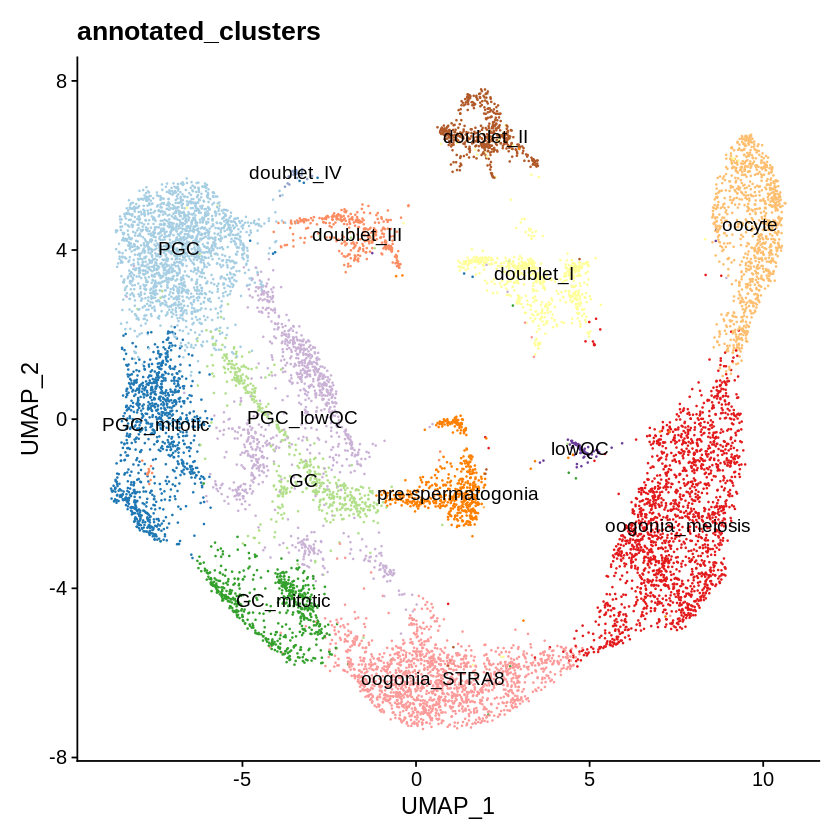

Saving 13.3 x 13.3 in image



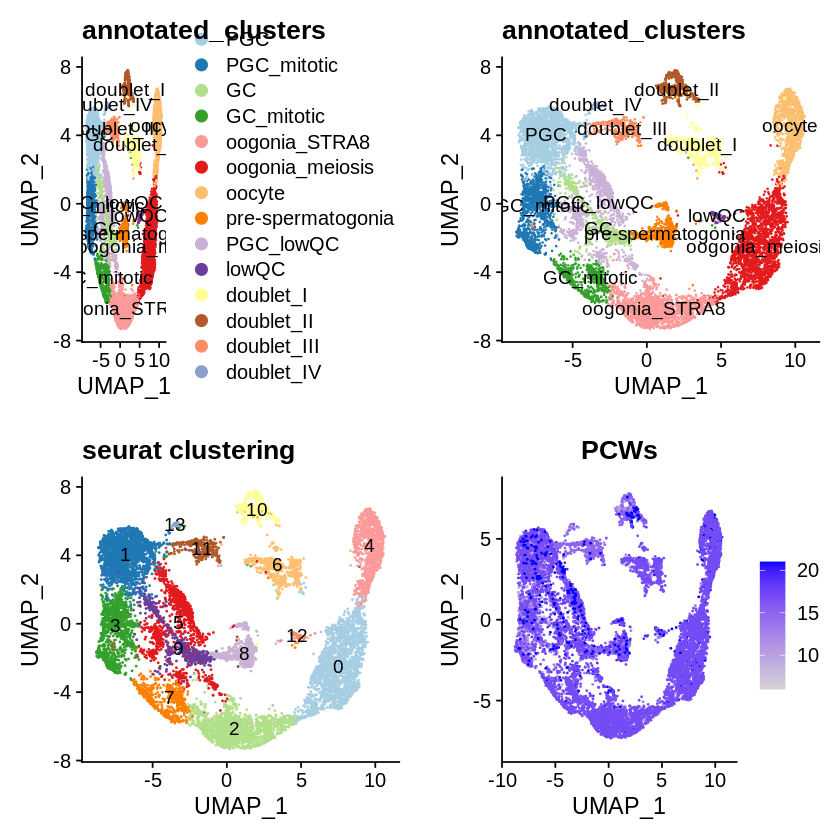

In [40]:
p1b = DimPlot(anndata, reduction = "umap", group.by = 'annotated_clusters', label = T, pt.size = 0.1,
             cols = colors[-1] ) + ggtitle('annotated_clusters')
p1b+ NoLegend()

plot_grid(p1b, p1b+ NoLegend(), p1, p3, ncol = 2)
ggsave(filename = paste0('figures-germcells/umap_annotated.pdf'), dpi = 75, scale = 2)

Saving 10.7 x 10.7 in image



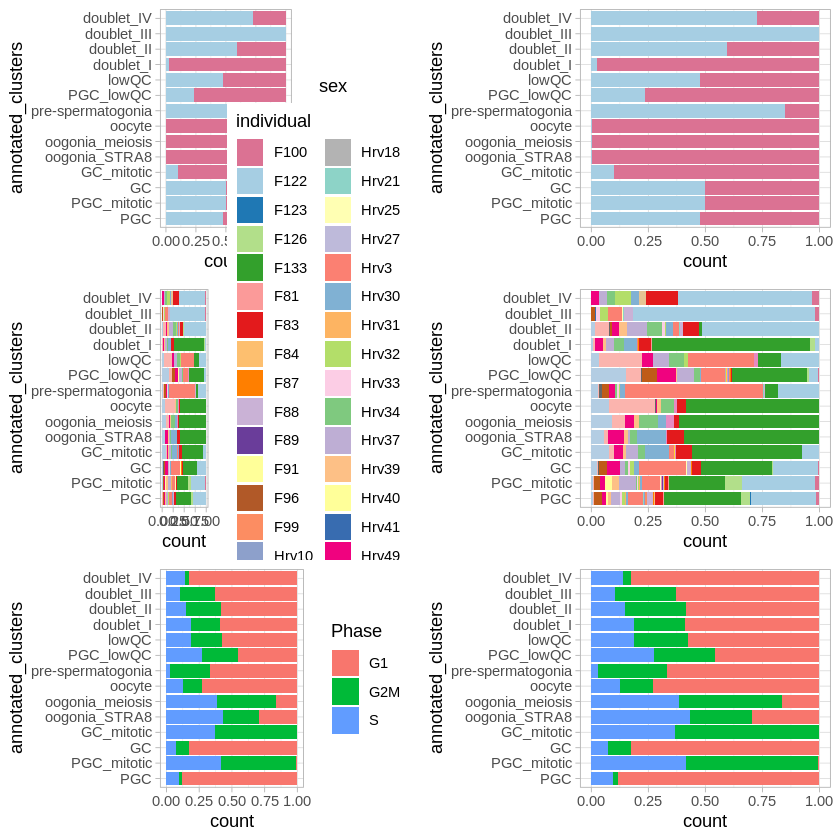

In [41]:
b1 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = sex)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b2 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = individual)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    scale_fill_manual(values = colors) + theme_light()

b3 = ggplot(anndata@meta.data, aes(x = annotated_clusters, fill = Phase)) + 
    geom_bar(position = 'fill') + 
    coord_flip() +
    theme_light()
plot_grid(b1, b1+NoLegend(), b2, b2+NoLegend(),  b3, b3+NoLegend(), ncol = 2)
ggsave(filename = paste0('figures-germcells/barplots_annotated.pdf'), dpi = 75, scale = 1.6)

Saving 12 x 6.67 in image



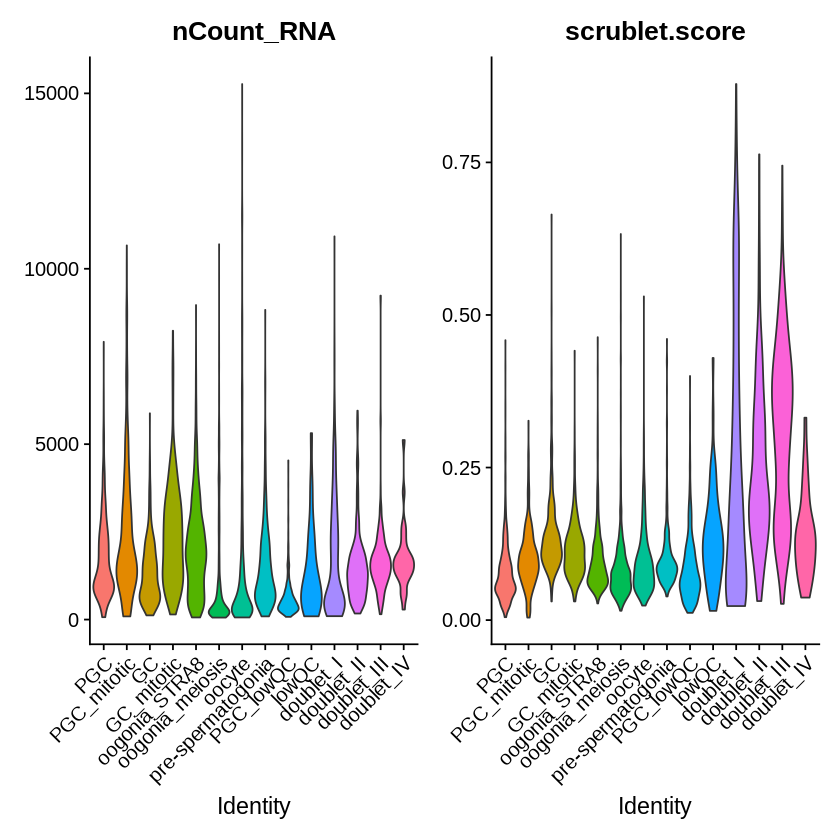

In [42]:
VlnPlot(anndata, c('nCount_RNA', 'scrublet.score'), group.by = 'annotated_clusters', pt.size = 0)
ggsave(filename = paste0('figures-germcells/boxplots_annotated.pdf'), dpi = 75, width = 12)

# TFIDF and Markers

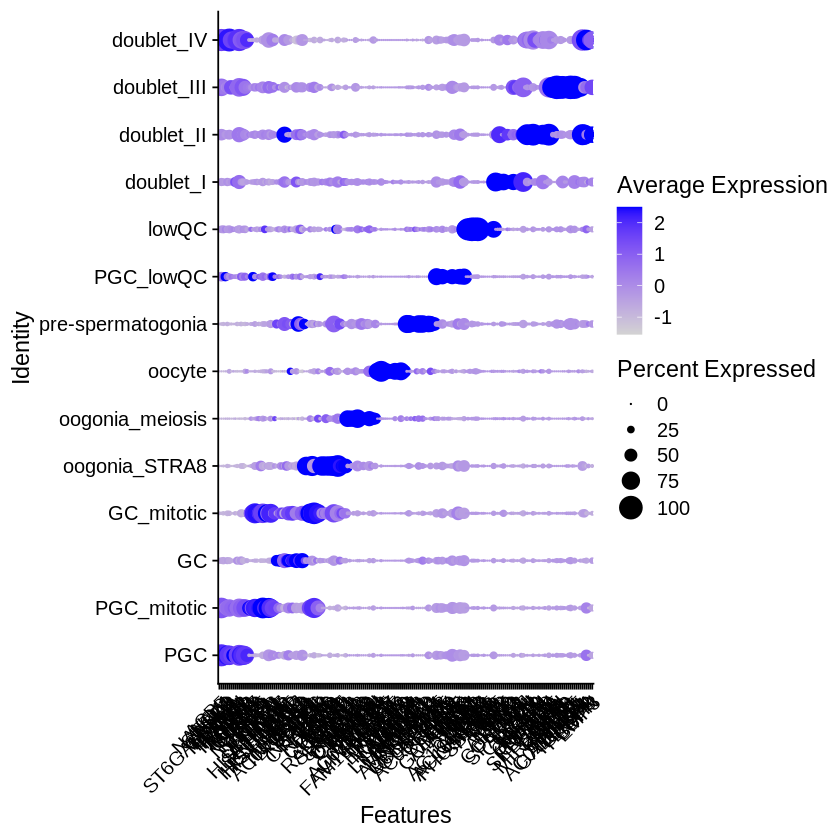

In [43]:
df_tfIDF = quickMarkers(toc = anndataO@assays$RNA@counts, clusters = Idents(anndataO), N = 100)
write.csv(df_tfIDF, file = 'figures-germcells/cluster_markersTFIDF_annotated.csv', quote = F, row.names = F)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(anndataO@meta.data$annotated_clusters) )
DEGs_tfIDF = subset(df_tfIDF, qval <= 0.01) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 15L)$gene) %>%
  unlist(.)
DotPlot(anndataO, features = unique(DEGs_tfIDF)) + RotatedAxis()
ggsave(filename = paste0('figures-germcells/dotplot_TFIDF_DEGs_annotated.pdf'), dpi = 75, height = 5, width = 45)

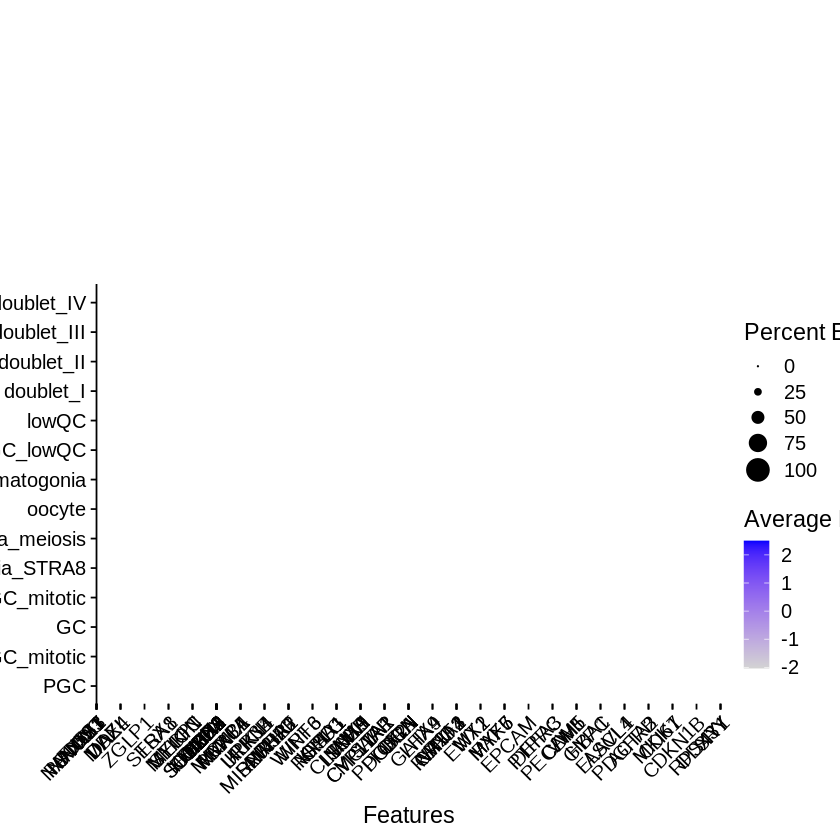

In [44]:
DotPlot(anndataO, features = markers, group.by = 'annotated_clusters') + RotatedAxis() + theme(strip.text.x = element_text(angle=90, hjust=0),
                                                                                            strip.background = element_rect(fill="#e8eced"))
ggsave(filename = paste0('figures-germcells/dotplot_markers_annotated.pdf'), dpi = 75, height = 7, width = 25)

# Save

In [45]:
write.csv(anndata@meta.data, file = paste0('figures-germcells/annotated_withdoublets.csv'), quote = F, row.names = T)
write.csv(anndata@meta.data, file = '/nfs/team292/lg18/with_valentina/germcells_annotation_doublets.csv', quote = F, row.names = T)
saveRDS(anndataO, file = '/nfs/team292/lg18/with_valentina/germcells_doublets.rds')